In [12]:
import numpy as np
from numpy import sin, cos, exp, pi, log, sqrt
import matplotlib.pyplot as plt
import emcee
import corner

In [72]:
mu0 = 1e25 #GUT scale
vH = 250*1e9
betak = 35/6
moves = [
    emcee.moves.StretchMove(a=1.5),
    emcee.moves.DEMove(),             # differential evolution
]

#Normal hierarchy values
obs_msq21 = 7.5*1e-5
obs_msq31 = 2.55*1e-3
obs_s12sq = 3.18*1e-1
obs_s23sq = 5.74*1e-1
obs_s13sq = 2.2*1e-2
#obs_CP = 1.08*pi

sigma_msq21 = 0.21*1e-5
sigma_msq31 = 0.025*1e-3
sigma_s12sq = 0.16*1e-1
sigma_s23sq = 0.14*1e-1
sigma_s13sq = 0.065*1e-2
#sigma_CP = 0.125*pi

#CL Yukawa coefficients
ye = 0.51099895000*1e6*sqrt(2)/(250*1e9)
ymu = 105.6583755*1e6*sqrt(2)/(250*1e9)
ytau = 1776.93*1e6*sqrt(2)/(250*1e9)

#1-loop beta function solution
def g(g0, k, v):
    return (g0**(-2) + (k/(8*pi**2))*log(v/mu0))**(-1/2)

#Mass
def Mnu(k, g0, ve, vmu, vtau):
    ge = g(g0, k, ve)
    gmu = g(g0, k, vmu)
    gtau = g(g0, k, vtau)
    return np.array([[np.exp(-8*np.pi**2/(ge**2))*ye, 0, 0],
                     [0, np.exp(-8*np.pi**2/(gmu**2))*ymu, 0],
                     [0,0,np.exp(-8*np.pi**2/(gtau**2))*ytau]])

#Mixing
def Inu(k, g0, ve, vmu, vtau):
    ge = g(g0, k, ve)
    gmu = g(g0, k, vmu)
    gtau = g(g0, k, vtau)
    inste = np.exp(-8*np.pi**2/(ge**2))
    instmu = np.exp(-8*np.pi**2/(gmu**2))
    insttau = np.exp(-8*np.pi**2/(gtau**2))
    remu = ve/vmu
    retau = ve/vtau
    rmutau = vmu/vtau
    return 0.01*np.array([[inste*ye, inste*ye/remu, inste*ye/retau],
                         [instmu*ymu*remu, instmu*ymu, instmu*ymu/rmutau],
                         [insttau*ytau*retau, insttau*ytau*rmutau, insttau*ytau]])

def log_prob(theta):
    g0 = theta[0]
    ve, vmu, vtau = 10**theta[1:]
    if (np.any(theta[1:] < 12)):
        return -np.inf
    if np.any(theta[1:] > 23):
        return -np.inf
    if np.any(g0**(-2) + (betak/(8*pi**2))*log(10**theta[1:]/mu0) <= 0):
        return -np.inf
    if g0 <= 0:
        return -np.inf
    if not (ve > vmu and vmu > vtau):
        return -np.inf

    Y = (vH/sqrt(2))*(Mnu(betak, g0, ve, vmu, vtau) + Inu(betak, g0, ve, vmu, vtau)) #Neutrino Yukawa after EWSB

    eigenvals, U = np.linalg.eig(Y)
    masses = np.abs(eigenvals)
    if np.sum(masses) > 0.2:
        return -np.inf

    dmsq21 = masses[1]**2 - masses[0]**2
    dmsq31 = masses[2]**2 - masses[0]**2

    s13sq = U[0,2]**2
    if s13sq <= 0 or s13sq >= 1:
        return -np.inf
    s12sq = (U[0,1]/sqrt(1-s13sq))**2
    s23sq = (U[1,2]/sqrt(1-s13sq))**2

    chi2 = ((dmsq21 - obs_msq21)/sigma_msq21)**2
    chi2 += ((dmsq31 - obs_msq31)/sigma_msq31)**2
    chi2 += ((s12sq - obs_s12sq)/sigma_s12sq)**2
    chi2 += ((s23sq - obs_s23sq)/sigma_s23sq)**2
    chi2 += ((s13sq - obs_s13sq)/sigma_s13sq)**2

    return -0.5*chi2

#v = np.logspace(13, 23, 1000)
#plt.plot(v, g(1, betak, v))
#plt.xscale('log')
#plt.show()    
    

[[ 0.68416267 18.43159066 16.92681685 13.61292566]
 [ 0.73009206 21.33051333 16.63292954 13.29868023]
 [ 0.70336779 20.36057054 16.82947838 12.95452801]
 ...
 [ 0.65022422 17.30080143 14.96201907 13.03537895]
 [ 0.64025473 19.43786558 19.21689513 17.26962536]
 [ 0.66488964 19.54477334 15.58665291 13.64274681]]
Acceptance fractions: [0.05662 0.07046 0.06944 0.05462 0.06737 0.07705 0.06665 0.05398 0.06813
 0.06904 0.0663  0.06924 0.06887 0.02609 0.07314 0.06971 0.07172 0.07305
 0.00675 0.07123]
Mean acceptance: 0.062473
Autocorrelation times: [5552.95181689 2112.40311178 5661.77166681 6166.32277979]


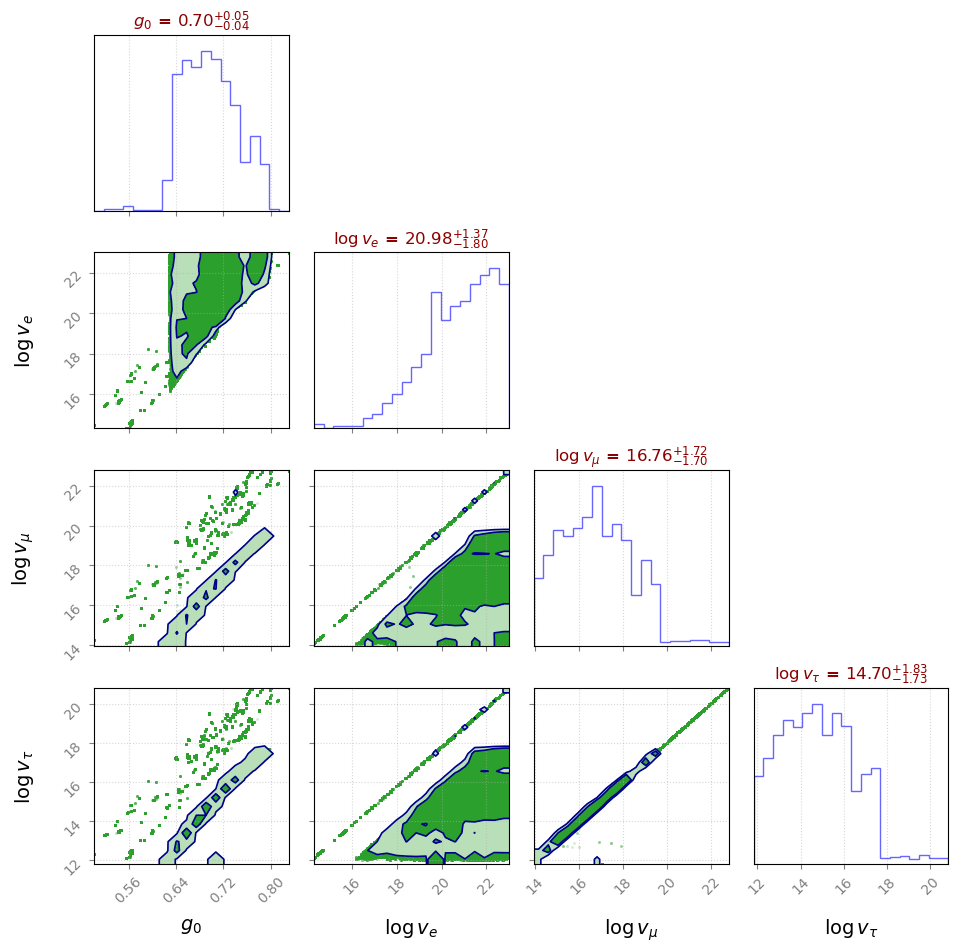

In [73]:
ndim = 4
nwalkers = 20
p0 = np.zeros((nwalkers, ndim))
p0[:,0] = 0.7 + 0.01*np.random.randn(nwalkers)
p0[:,1] = 20 + np.random.randn(nwalkers)
p0[:,2] = 16 + np.random.randn(nwalkers)
p0[:,3] = 14 + np.random.randn(nwalkers)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, moves=moves)
sampler.run_mcmc(p0, 100000)

samples = sampler.get_chain(flat=True)
print(samples)

af = sampler.acceptance_fraction  # shape (nwalkers,)
print("Mean acceptance:", af.mean())

try:
    tau = sampler.get_autocorr_time(tol=0)
    print("Autocorrelation times:", tau)
except Exception as e:
    print("Autocorr time 계산 실패:", e)

burnin = int(2 * tau.max())  # 예: 2×max autocorr time
samples = sampler.get_chain(discard=burnin, flat=True)  # shape (nwalkers*nsteps_discarded, ndim)

labels=[r"$g_0$",r"$\log{v_e}$",r"$\log{v_{\mu}}$",r'$\log{v_{\tau}}$']

# 2. corner 옵션으로 색상·글꼴·라인바꾸기
figure = corner.corner(
    samples,
    labels=labels,
    color="C2",                        # 컨투어·히스토그램 선 색
    hist_kwargs={
        "density": True,
        "color":  "blue",         # 히스토그램 바 색
        "alpha":  0.6
    },
    contour_kwargs={
        "colors":    ["darkblue"],     # 컨투어 라인 색
        "linewidths": 1.2
    },
    plot_datapoints=True,              # 산점도로도 보여주기
    plot_contours=True,                # 컨투어 레벨 표시
    fill_contours=True,                # 컨투어 내부 채우기
    levels=(0.68, 0.95),               # 1σ, 2σ 레벨
    show_titles=True,
    title_kwargs={
        "fontsize": 12,
        "fontweight": "bold",
        "color": "darkred"
    },
    label_kwargs={
        "fontsize": 14,
        "fontfamily": "serif"
    }
)

# 3. 축·폰트·백그라운드 추가 커스터마이징
for ax in figure.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=10, colors='gray')
    ax.grid(True, linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()